In [10]:
!pip install imbalanced-learn
!pip install -q kaggle

In [11]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"pouyanorouzi","key":"924ac920ea27e817cf226187aa7e5ad3"}'}

In [15]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [16]:
!chmod 600 /root/.kaggle/kaggle.json

In [20]:
!kaggle datasets download -d fedesoriano/stroke-prediction-dataset

100% 67.4k/67.4k [00:00<00:00, 271kB/s]
100% 67.4k/67.4k [00:00<00:00, 271kB/s]


In [21]:
!unzip stroke-prediction-dataset.zip

Archive:  stroke-prediction-dataset.zip
  inflating: healthcare-dataset-stroke-data.csv  


### Import necessaries

In [23]:
import numpy as np
import pandas as pd
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, RMSprop

In [24]:
df = pd.read_csv(r"/content/healthcare-dataset-stroke-data.csv")
df = df.dropna()
df.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


### Processing Part

In [25]:
X = df.drop(['id', 'stroke'], axis = 1)
y = df['stroke']
X = pd.get_dummies(X)

### Spiliting Dataset

In [26]:
oversampler = SMOTETomek(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

In [27]:
X_train, X_remaining, y_train, y_remaining = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)


### Train Calssifier Until we get at least 80 precent accuracy for validation set


In [29]:
accuracy_valid = 0
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)
y_valid_pred = classifier.predict(X_valid)
accuracy_valid = accuracy_score(y_valid, y_valid_pred)


Test Set:
Accuracy: 0.9715665236051502
Confusion Matrix:
[[935   8]
 [ 45 876]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       943
           1       0.99      0.95      0.97       921

    accuracy                           0.97      1864
   macro avg       0.97      0.97      0.97      1864
weighted avg       0.97      0.97      0.97      1864



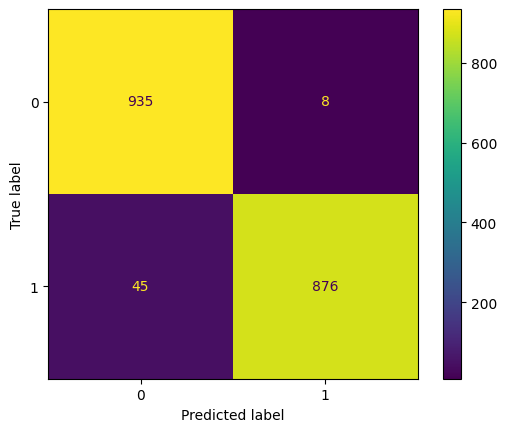

In [30]:
y_test_pred = classifier.predict(X_test)

accuracy_test = accuracy_score(y_test, y_test_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
classification_rep_test = classification_report(y_test, y_test_pred)

print("\nTest Set:")
print(f"Accuracy: {accuracy_test}")
print(f"Confusion Matrix:\n{conf_matrix_test}")
print(f"Classification Report:\n{classification_rep_test}")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test,display_labels=classifier.classes_)
disp.plot()
plt.show()

In [31]:
def build_ann(optimizer='optimizer'):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [32]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [33]:
model_adam = build_ann(optimizer='adam')
history_adam = model_adam.fit(X_train_scaled, y_train, epochs=50, batch_size=64, validation_data=(X_valid_scaled, y_valid), verbose=0)
model_rmsprop = build_ann(optimizer='rmsprop')
history_rmsprop = model_rmsprop.fit(X_train_scaled, y_train, epochs=50, batch_size=64, validation_data=(X_valid_scaled, y_valid), verbose=0)

In [34]:
def evaluate_model(model, X, y):
    y_pred_prob = model.predict(X)
    y_pred = np.round(y_pred_prob)
    accuracy = accuracy_score(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred)
    classification_rep = classification_report(y, y_pred)
    return accuracy, conf_matrix, classification_rep

In [35]:
accuracy_adam, conf_matrix_adam, classification_rep_adam = evaluate_model(model_adam, X_test_scaled, y_test)
accuracy_rmsprop, conf_matrix_rmsprop, classification_rep_rmsprop = evaluate_model(model_rmsprop, X_test_scaled, y_test)


59/59 [==============================] - 0s 1ms/step



Adam Optimizer:
Accuracy: 0.9603004291845494
Confusion Matrix:
[[919  24]
 [ 50 871]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       943
           1       0.97      0.95      0.96       921

    accuracy                           0.96      1864
   macro avg       0.96      0.96      0.96      1864
weighted avg       0.96      0.96      0.96      1864



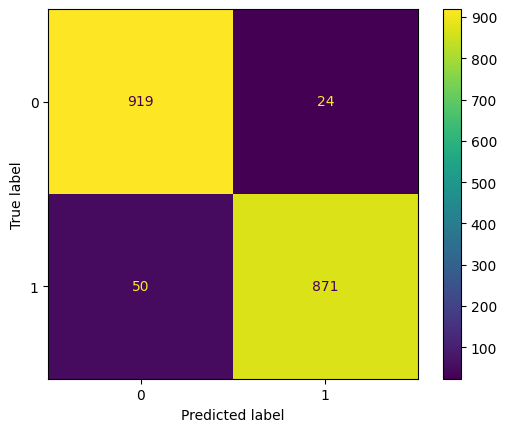


RMSprop Optimizer:
Accuracy: 0.9629828326180258
Confusion Matrix:
[[928  15]
 [ 54 867]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       943
           1       0.98      0.94      0.96       921

    accuracy                           0.96      1864
   macro avg       0.96      0.96      0.96      1864
weighted avg       0.96      0.96      0.96      1864



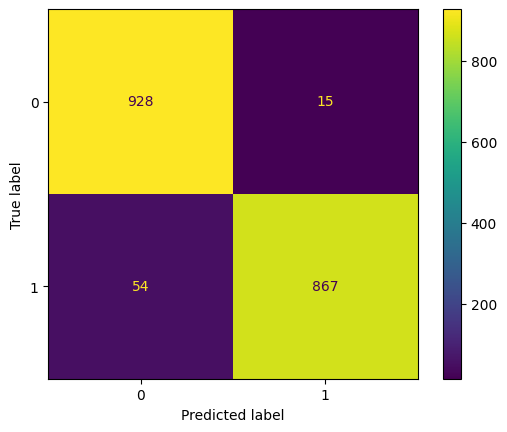

In [36]:
print("\nAdam Optimizer:")
print(f"Accuracy: {accuracy_adam}")
print(f"Confusion Matrix:\n{conf_matrix_adam}")
print(f"Classification Report:\n{classification_rep_adam}")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_adam,display_labels=classifier.classes_)
disp.plot()
plt.show()
print("\nRMSprop Optimizer:")
print(f"Accuracy: {accuracy_rmsprop}")
print(f"Confusion Matrix:\n{conf_matrix_rmsprop}")
print(f"Classification Report:\n{classification_rep_rmsprop}")
dispp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rmsprop,display_labels=classifier.classes_)
dispp.plot()
plt.show()